## About
In a recent project, we decided to use AUC-Recall@K as our primary metric for evaluating our model. We defined it as the proportion of area under an ideal Recall@k curve that our model achieved.

My first implementation used NumPy's functions and the performance wasn't bad at all, but it made me wonder how much better I could have done.. and how much worse.

This notebook contains the code discussed in the accompanying blogpost on Medium.com.

**Note**  
The exact times you get may vary.

### Imports and Config

In [1]:
import sklearn
from sklearn.metrics import make_scorer
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

In [2]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [15, 8]

### Experiments

In [3]:
def auc_recall_at_k(y_true, y_conf):
    """
    Compute AUC under the Recall@k curve.

    y_true: A numpy array of expected predictions
    y_conf: A numpy array of the model's confidence
            scores for each datapoint
            
    Returns: AUC-Recall@k (float)
    """

    # if there are no positive targets (good leads),
    # auc becomes invalid
    if y_true.count(1) == 0:
        return np.nan

    conf_df = pd.DataFrame()
    conf_df["conf"] = y_conf
    conf_df["expected"] = y_true
    conf_df.columns = ["conf", "expected"]
    conf_df = conf_df.sort_values("conf", ascending=False)

    recall_at_k = []

    # calculating recall@k
    for i in range(len(conf_df)):
        recall_at_k.append(
            conf_df.iloc[:i+1, :]["expected"].to_list().count(1)
            / conf_df["expected"].to_list().count(1)
        )

    # calculating ideal recall@k
    ideal_recall_at_k = np.minimum(
        np.ones(len(conf_df)),
        np.array(list(range(1, len(conf_df["expected"]) + 1)))/ conf_df["expected"].to_list().count(1)
    )

    # Computing our final metric by getting the proportion of the areas
    # under these two curves
    return np.trapz(recall_at_k) / np.trapz(ideal_recall_at_k)

In [4]:
def auc_recall_at_k_np(y_true, y_conf):
    """
    Experiment #2:
    --------------
    Compute AUC under the Recall@k curve using numpy's
    functions.

    y_true: A numpy array of expected predictions
    y_conf: A numpy array of the model's confidence
            scores for each datapoint
            
    Returns: AUC-Recall@k (float)
    """

    # if there are no positive targets (good leads),
    # auc becomes invalid
    if y_true.count(1) == 0:
        return np.nan

    conf_df = pd.DataFrame()
    conf_df["conf"] = y_conf
    conf_df["expected"] = y_true
    conf_df.columns = ["conf", "expected"]
    conf_df = conf_df.sort_values("conf", ascending=False)

    ranking = conf_df["expected"].to_numpy()

    recall_at_k = (ranking == 1).cumsum() / (ranking == 1).sum()

    # calculating ideal recall@k
    ideal_recall_at_k = np.minimum(
        np.ones(len(ranking)),
         np.array(list(range(1, len(ranking) + 1)))/ (ranking == 1).sum()
    )

    return np.trapz(recall_at_k) / np.trapz(ideal_recall_at_k)

In [5]:
def auc_recall_at_k_np_no_df(y_true, y_conf):
    """
    Experiment #3:
    --------------
    Compute AUC under the Recall@k curve using numpy's
    functions. We do away with the conf_df dataframe 
    as well.

    y_true: A numpy array of expected predictions
    y_conf: A numpy array of the model's confidence
            scores for each datapoint
            
    Returns: AUC-Recall@k (float)
    """

    # if there are no positive targets (good leads),
    # auc becomes invalid
    if (y_true == 1).sum() == 0:
        return np.nan

    ranking = y_true[np.argsort(y_conf)[::-1]]

    # calculating recall@k based on sorted ranking
    recall_at_k = (ranking == 1).cumsum() / (ranking == 1).sum()

    # calculating ideal recall@k
    ideal_recall_at_k = np.minimum(
        np.ones(len(ranking)),
         np.array(list(range(1, len(ranking) + 1)))/ (ranking == 1).sum()
    )

    return np.trapz(recall_at_k) / np.trapz(ideal_recall_at_k)

In [6]:
@jit
def auc_recall_at_k_np_no_df_numba(y_true, y_conf):
    """
    Experiment #4:
    --------------
    Compute AUC under the Recall@k curve using numpy's
    functions. We do away with the conf_df dataframe 
    as well.

    Numba's jit decorator is also added for further 
    optimization.

    y_true: A numpy array of expected predictions
    y_conf: A numpy array of the model's confidence
            scores for each datapoint
            
    Returns: AUC-Recall@k (float)
    """

    # if there are no positive targets (good leads),
    # auc becomes invalid
    if (y_true == 1).sum() == 0:
        return np.nan

    ranking = y_true[np.argsort(y_conf)[::-1]]

    # calculating recall@k based on sorted ranking
    recall_at_k = (ranking == 1).cumsum() / (ranking == 1).sum()

    # calculating ideal recall@k
    ideal_recall_at_k = np.minimum(
        np.ones(len(ranking)),
         np.array(list(range(1, len(ranking) + 1)))/ (ranking == 1).sum()
    )

    return np.trapz(recall_at_k) / np.trapz(ideal_recall_at_k)

### On a dataset of size 5

In [7]:
t1 = %timeit -o auc_recall_at_k([1, 0, 1, 1, 0], [0.9, 0.8, 0.7, 0.6, 0.5])

2.73 ms ± 63.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
t2 = %timeit -o auc_recall_at_k_np([1, 0, 1, 1, 0], [0.9, 0.8, 0.7, 0.6, 0.5])

2.09 ms ± 56.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
t3 = %timeit -o auc_recall_at_k_np_no_df(np.array([1, 0, 1, 1, 0]), [0.9, 0.8, 0.7, 0.6, 0.5])

76.1 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
t4 = %timeit -o auc_recall_at_k_np_no_df_numba(np.array([1, 0, 1, 1, 0]), np.array([0.9, 0.8, 0.7, 0.6, 0.5]))

The slowest run took 7.59 times longer than the fastest. This could mean that an intermediate result is being cached.
18.5 µs ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


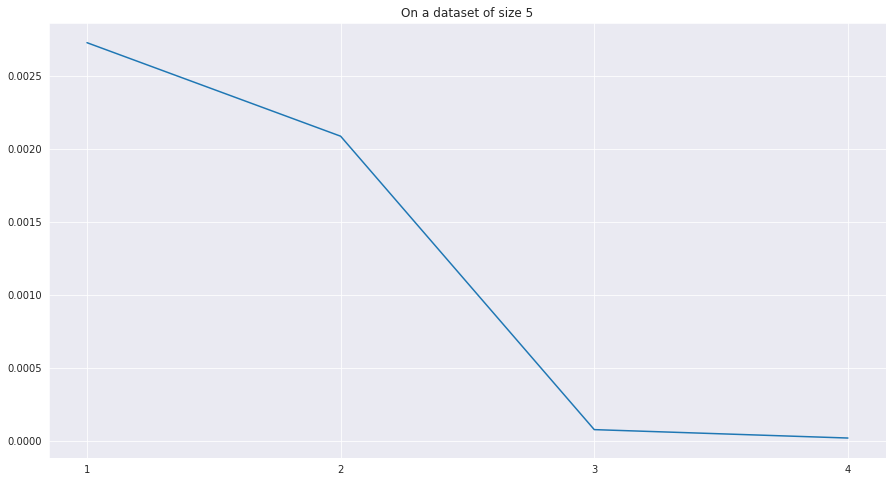

In [13]:
plt.title("On a dataset of size 5")
_ = plt.plot(["1", "2", "3", "4"], [t1.average, t2.average, t3.average, t4.average])

### On a dataset of size 100

In [14]:
t1 = %timeit -o auc_recall_at_k(list(np.random.randint(0, 2, 100)), np.random.rand(100))

16.4 ms ± 642 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
t2 = %timeit -o auc_recall_at_k_np(list(np.random.randint(0, 2, 100)), np.random.rand(100))

2.28 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
t3 = %timeit -o auc_recall_at_k_np_no_df(np.random.randint(0, 2, 100), np.random.rand(100))

89.1 µs ± 2.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
t4 = %timeit -o auc_recall_at_k_np_no_df_numba(np.random.randint(0, 2, 100), np.random.rand(100))

49.2 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


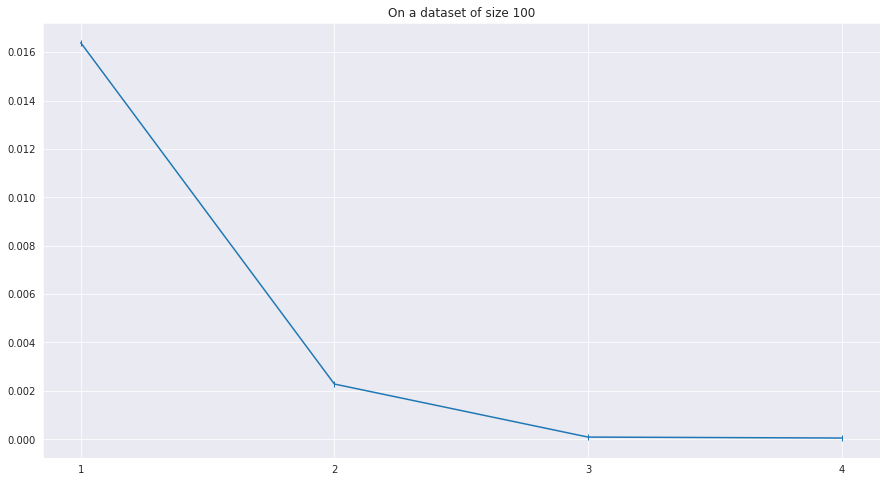

In [19]:
plt.title("On a dataset of size 100")
_ = plt.plot(
    ["1", "2", "3", "4"],
    [t1.average, t2.average, t3.average, t4.average],
    marker="|"
)

### On a dataset of size 10k

In [20]:
t1 = %timeit -o auc_recall_at_k(list(np.random.randint(0, 2, 10000)), np.random.rand(10000))

6.34 s ± 882 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
t2 = %timeit -o auc_recall_at_k_np(list(np.random.randint(0, 2, 10000)), np.random.rand(10000))

11.7 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
t3 = %timeit -o auc_recall_at_k_np_no_df(np.random.randint(0, 2, 10000), np.random.rand(10000))

2.28 ms ± 60.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
t4 = %timeit -o auc_recall_at_k_np_no_df_numba(np.random.randint(0, 2, 10000), np.random.rand(10000))

1.5 ms ± 51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


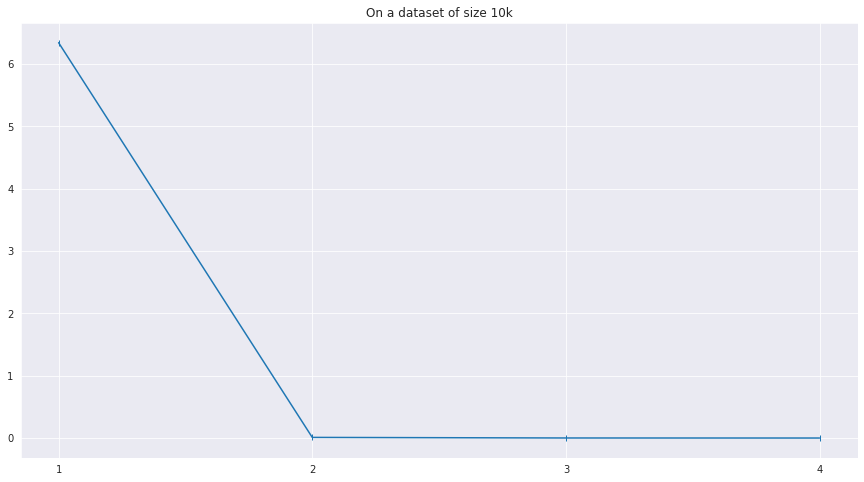

In [24]:
plt.title("On a dataset of size 10k")
_ = plt.plot(
    ["1", "2", "3", "4"],
    [t1.average, t2.average, t3.average, t4.average],
    marker="|"
)

### On a dataset of size 100k
**Note**   
The baseline implementation takes over 6min for running on a dataset of this size. If using the timeit code below, reduce the number of runs to 1 since the default of 7 runs would take a while to finish running.

In [ ]:
t1 = %timeit -o -n 1 -r 1 auc_recall_at_k(
    list(np.random.randint(0, 2, 100000)),
    np.random.rand(100000)
)

6min 5s ± 2.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
t2 = %timeit -o auc_recall_at_k_np(list(np.random.randint(0, 2, 100000)), np.random.rand(100000))

103 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
t3 = %timeit -o auc_recall_at_k_np_no_df(np.random.randint(0, 2, 100000), np.random.rand(100000))

30.5 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
t4 = %timeit -o auc_recall_at_k_np_no_df_numba(np.random.randint(0, 2, 100000), np.random.rand(100000))

19.1 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


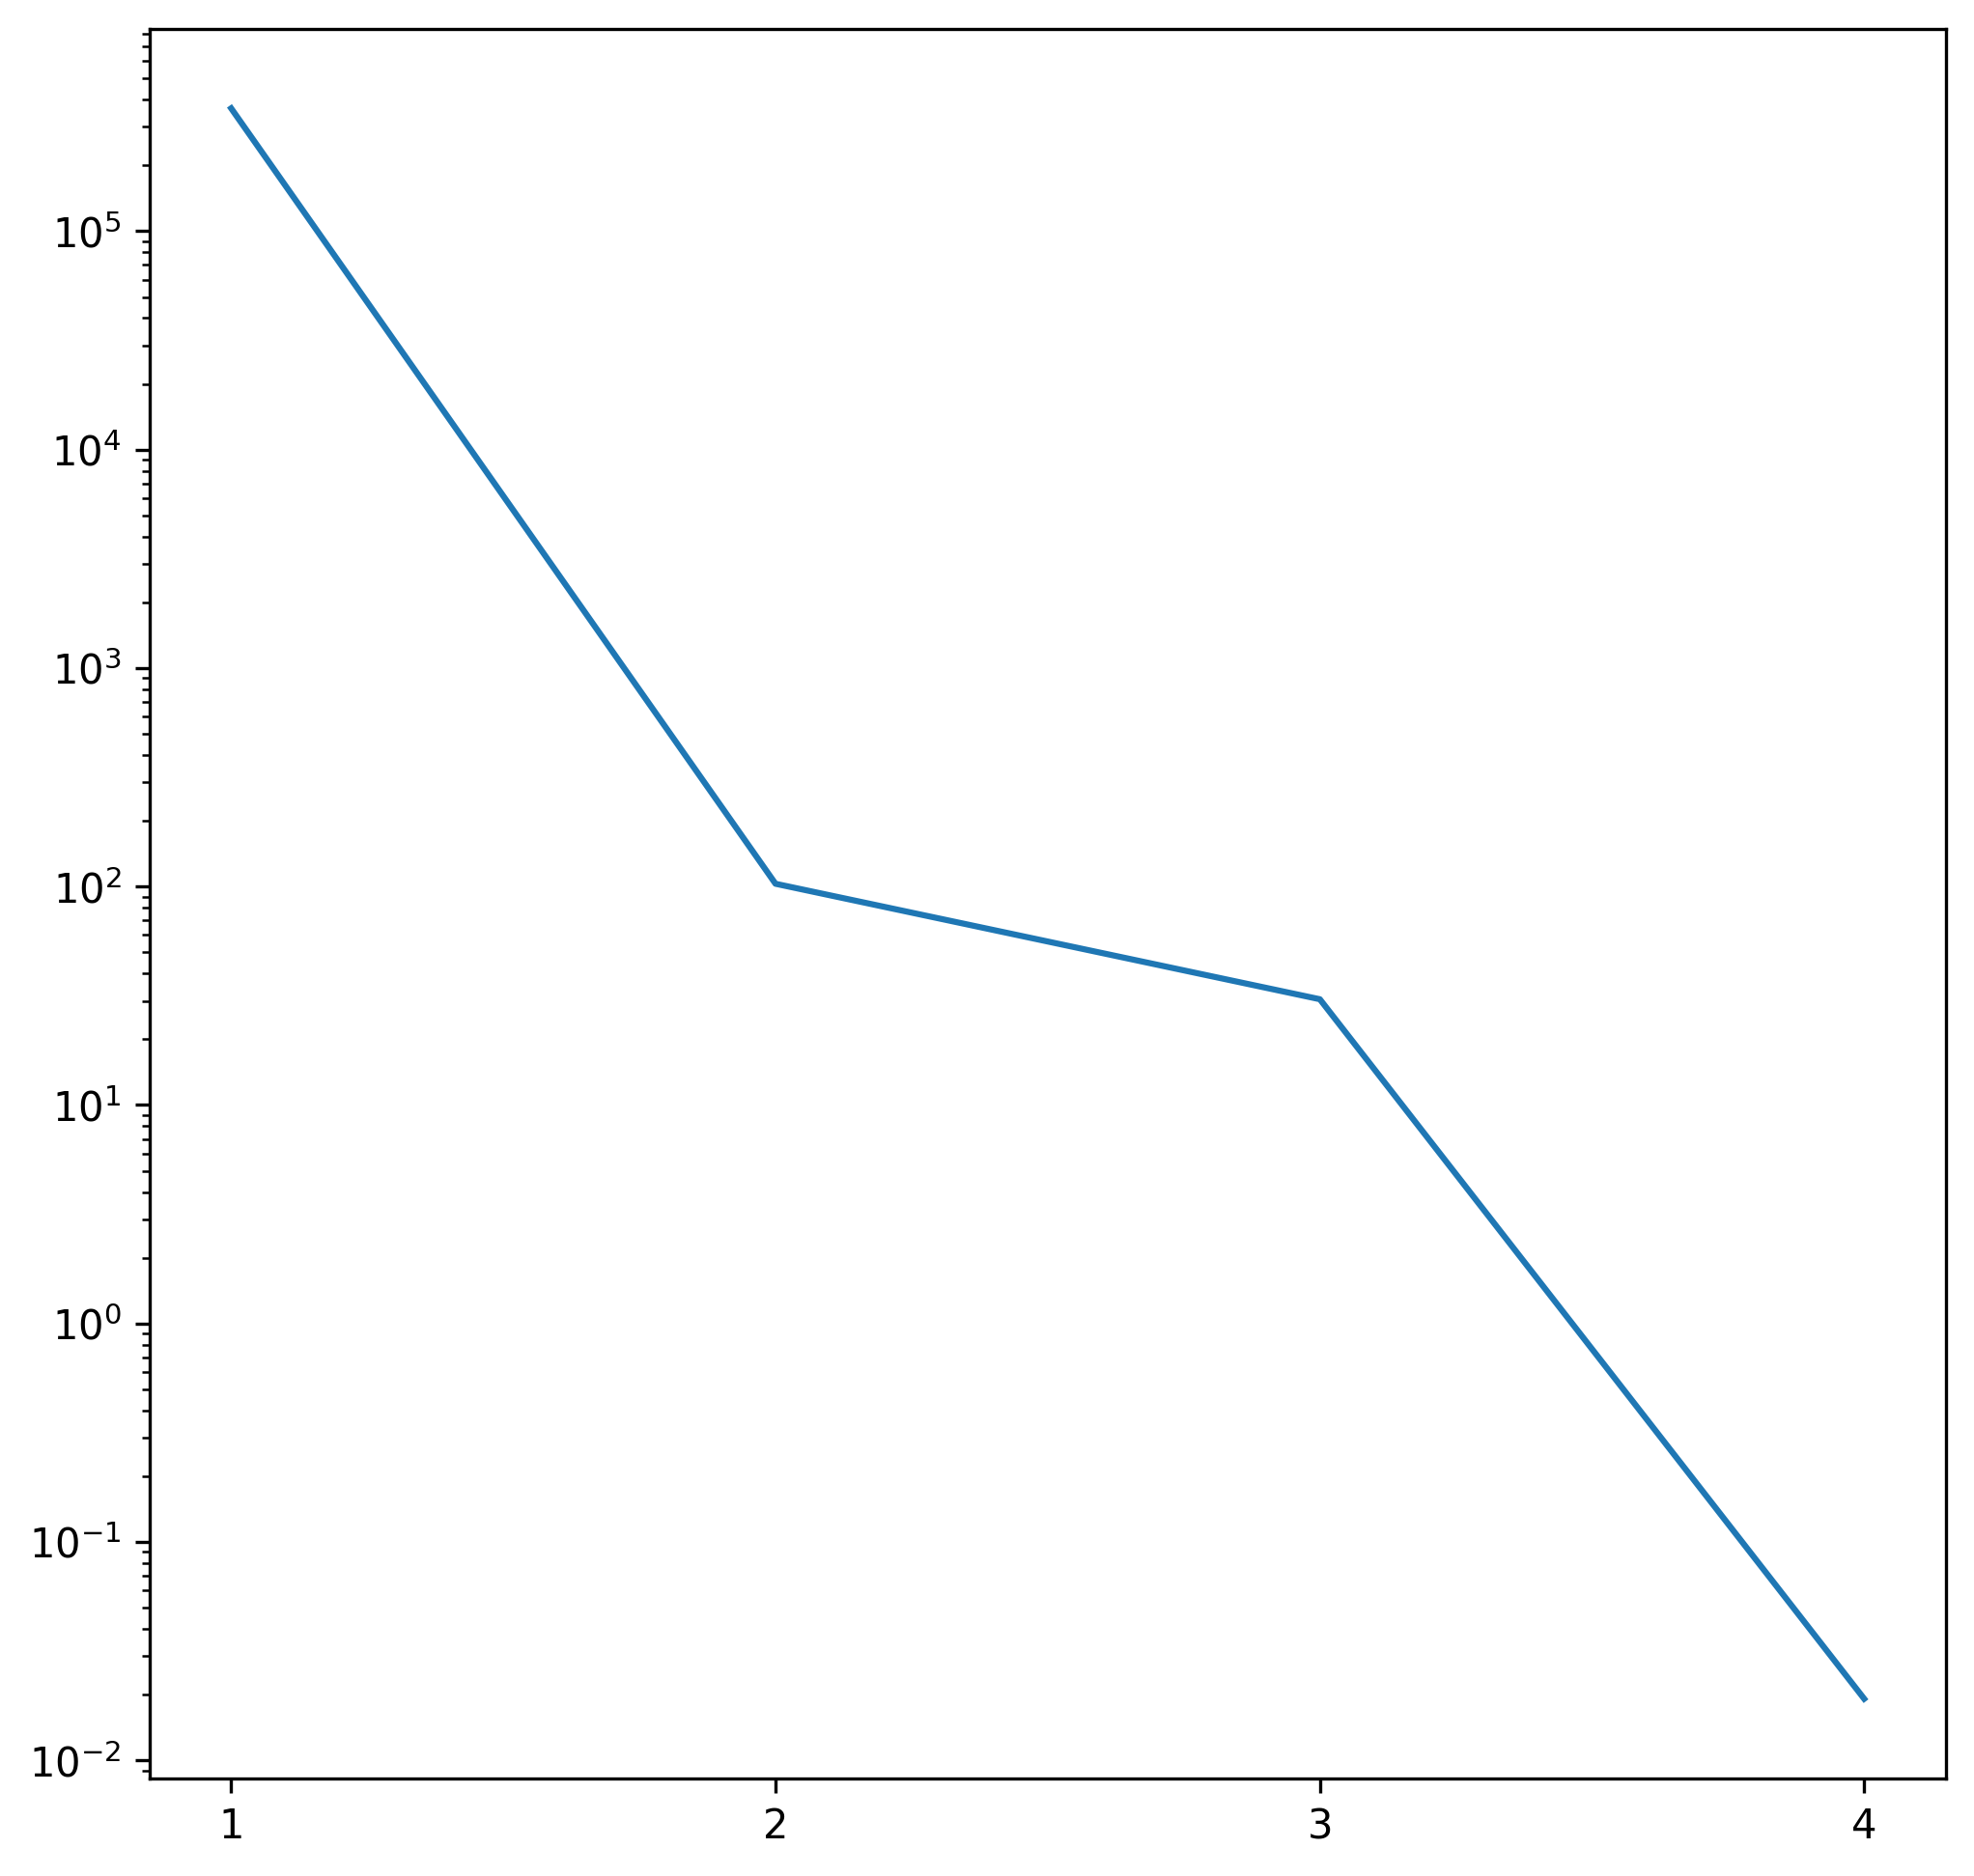

In [ ]:
# converting to a log scale
plt.yscale("log")
plt.title("On a dataset of size 100k")
_ = plt.plot(
    ["1", "2", "3", "4"],
    [t1.average, t2.average, t3.average, t4.average],
    marker="|"
)